# Imports

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf

import matplotlib.pyplot as plt

# Function

In [3]:
def plot_results(history, epochs):
  acc = history.history['Accuracy']
  val_acc = history.history['val_Accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_intervals = range(epochs)
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_intervals, acc, label='Train Accuracy')
  plt.plot(epochs_intervals, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_intervals, loss, label='Train Loss')
  plt.plot(epochs_intervals, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.show()

# Data

In [4]:
df = pd.read_csv('https://github.com/allanspadini/curso-tensorflow-proxima-palavra/raw/main/dados/train.zip', 
                 names=['ClassIndex', 'Título', 'Descrição'], header=None)

In [3]:
df.head()

,ClassIndex,Título,Descrição
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


# Preprocessing

## Features

In [5]:
df['text'] = df['Título'] + df['Descrição']

In [6]:
df.head()

,ClassIndex,Título,Descrição,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [6]:
df['ClassIndex'] -= 1

In [9]:
df['ClassIndex'].unique()

array([2, 3, 1, 0])

## Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['ClassIndex'].values, random_state=7, test_size=0.2)

## Encoder

In [8]:
VOCAB_SIZE = 1_000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

2025-02-28 08:50:05.630184: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
encoder.adapt(X_train)

In [17]:
encoder.get_vocabulary()[:5]

['', '[UNK]', np.str_('the'), np.str_('to'), np.str_('a')]

In [19]:
encoder('This is an example')

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([41, 16, 24,  1])>

# Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=16,
        mask_zero=True
    ),
    tf.keras.layers.GlobalAveragePooling1D(), # Dimensionality reduction
    tf.keras.layers.Dense(16, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(4, activation='softmax') # Output
])

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (1, None)              │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (1, None, 16)          │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (1, 16)                │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 16)                │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 4)                 │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (63.83 KB)

 Trainable params: 16,340 (63.83 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [13]:
epochs = 10

In [12]:
history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - Accuracy: 0.4949 - loss: 1.3265 - val_Accuracy: 0.7563 - val_loss: 0.9604
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.7752 - loss: 0.8440 - val_Accuracy: 0.8061 - val_loss: 0.6274
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8136 - loss: 0.5900 - val_Accuracy: 0.8240 - val_loss: 0.5290
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8261 - loss: 0.5177 - val_Accuracy: 0.8320 - val_loss: 0.4905
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8395 - loss: 0.4773 - val_Accuracy: 0.8382 - val_loss: 0.4700
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8446 - loss: 0.4600 - val_Accuracy: 0.8422 - val_loss: 0.4577
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8473 - loss: 0.4492 - val_Accuracy: 0.8461 - val_loss: 0.4492
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8504 - loss: 0

In [35]:
model.predict(X_test[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[2.41511315e-03, 9.97438312e-01, 2.98898049e-05, 1.16686875e-04]],
      dtype=float32)

In [36]:
model.predict(X_test[0:1]).argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([1])

In [37]:
y_test[0]

np.int64(1)

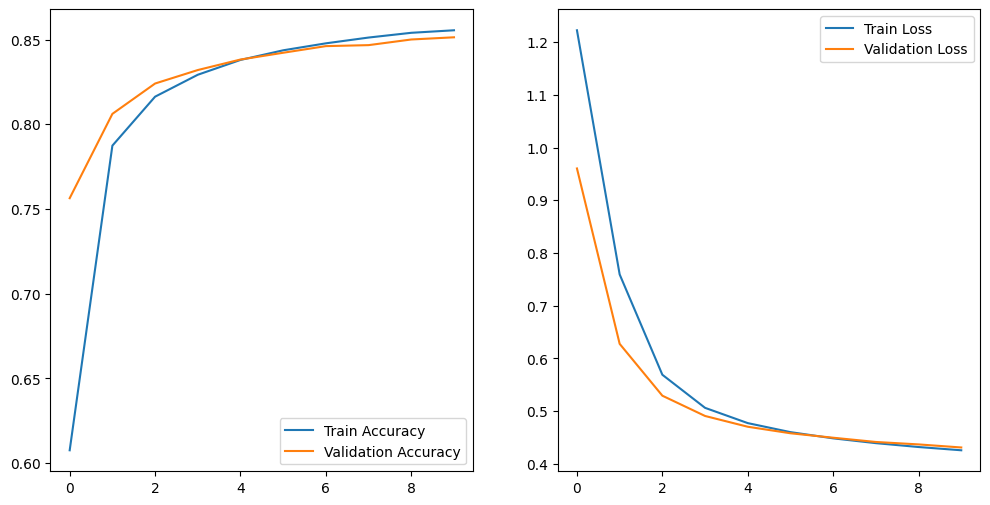

In [14]:
plot_results(history, epochs)

## CONV Layer

In [16]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=16,
        mask_zero=False
    ),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(128, kernel_size=4, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(), # Dimensionality reduction
    tf.keras.layers.Dense(16, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(4, activation='softmax') # Output
])

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [18]:
history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - Accuracy: 0.5115 - loss: 1.1055 - val_Accuracy: 0.8138 - val_loss: 0.5268
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - Accuracy: 0.8239 - loss: 0.5059 - val_Accuracy: 0.8304 - val_loss: 0.4875
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - Accuracy: 0.8375 - loss: 0.4674 - val_Accuracy: 0.8354 - val_loss: 0.4743
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8416 - loss: 0.4522 - val_Accuracy: 0.8418 - val_loss: 0.4572
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8460 - loss: 0.4411 - val_Accuracy: 0.8455 - val_loss: 0.4440
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8491 - loss: 0.4301 - val_Accuracy: 0.8479 - val_loss: 0.4340
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8542 - loss: 0.4152 - val_Accuracy: 0.8539 - val_loss: 0.4190
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8574 - loss: 0

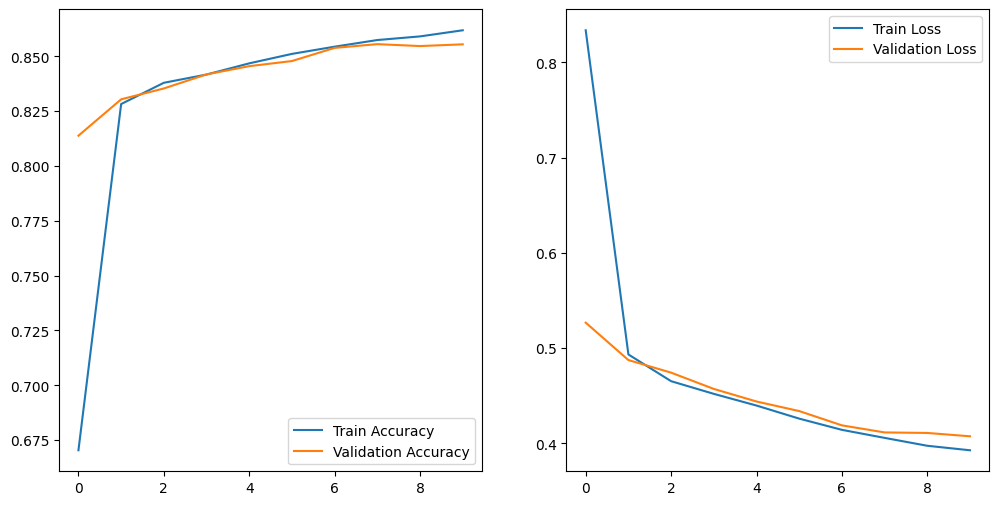

In [19]:
plot_results(history, epochs)

## LSTM

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'), # Hidden layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax') # Output
])

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [ ]:
epochs = 20

history = model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20


2025-02-28 09:11:24.987882: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 309s 101ms/step - Accuracy: 0.5531 - loss: 1.0092 - val_Accuracy: 0.8389 - val_loss: 0.4702
Epoch 2/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 275s 91ms/step - Accuracy: 0.7967 - loss: 0.5800 - val_Accuracy: 0.8538 - val_loss: 0.4329
Epoch 3/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 170s 57ms/step - Accuracy: 0.8119 - loss: 0.5479 - val_Accuracy: 0.8588 - val_loss: 0.4172
Epoch 4/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 168s 56ms/step - Accuracy: 0.8187 - loss: 0.5212 - val_Accuracy: 0.8599 - val_loss: 0.4081
Epoch 5/20
1550/3000 ━━━━━━━━━━━━━━━━━━━━ 1:12 50ms/step - Accuracy: 0.8306 - loss: 0.4951

In [ ]:
plot_results(history, epochs)